# <a id='toc1_'></a>[Mobile Robotics Project Report](#toc0_)

_École Polytéchnique Fédérale de Lausanne_

Marcus Cemes, Pablo Paller, Adrien Pannatier,  Carolina Rodrigues Fidalgo

<div style="background-color: #f9fafb; border: 1px solid #d1d5db; border-radius: 0.25rem; padding: 1rem 2rem;">
    This notebook describes the different parts of our project for the course MICRO-452: Basics of mobile robotics.<br/>
    In the following cells we will describe how the modules work and give a structure to run the project.
</div>

**Table of contents**<a id='toc0_'></a>    
- [Mobile Robotics Project Report](#toc1_)    
  - [Prerequisites](#toc1_1_)    
    - [Useful imports](#toc1_1_1_)    
  - [Introduction](#toc1_2_)    
    - [Features](#toc1_2_1_)    
    - [Architecture](#toc1_2_2_)    
    - [Useful concepts](#toc1_2_3_)    
      - [The Signal](#toc1_2_3_1_)    
      - [The Context](#toc1_2_3_2_)    
      - [The State](#toc1_2_3_3_)    
        - [State patches](#toc1_2_3_3_1_)    
      - [The Module class](#toc1_2_3_4_)    
      - [The Pool](#toc1_2_3_5_)    
      - [The Web UI](#toc1_2_3_6_)    
  - [Vision](#toc1_3_)    
    - [Calibration](#toc1_3_1_)    
    - [Frame analysis](#toc1_3_2_)    
  - [Filtering](#toc1_4_)    
    - [Prediction](#toc1_4_1_)    
    - [Update](#toc1_4_2_)    
  - [Global navigation](#toc1_5_)    
        - [Time for some obstacles](#toc1_5_1_1_1_)    
    - [Path optimisation](#toc1_5_2_)    
  - [Big Brain](#toc1_6_)    
    - [Significant updates](#toc1_6_1_)    
    - [Christmas animation](#toc1_6_2_)    
  - [Motion control](#toc1_7_)    
        - [Responsibilities](#toc1_7_1_1_1_)    
        - [Setup](#toc1_7_1_1_2_)    
        - [Simulation](#toc1_7_1_1_3_)    
  - [Local navigation](#toc1_8_)    
  - [Putting it all together](#toc1_9_)    
    - [Running from the terminal](#toc1_9_1_)    
    - [Running from Jupyter](#toc1_9_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Prerequisites](#toc0_)

<div class="alert alert-block alert-info">
    <b>Tip:</b> In the latest Python/Jupyter version, it should no longer be necsesary to add our application module to the path. If you experience any import errors, convert the following block to code and run it before anything else.
</div>

This project has been tested on **Python 3.10** and **JupyterLab 3.5**, allowing for features such as:

- Python's new `match` statement
- Top-level async/await
- Integrated event loop in the notebook

To make sure that your environment is supported, try running the following:

In [1]:
from report.utils import run_checks

run_checks()

🎉 Everything seems fine!


If you have any missing requirements, convert the following into a code block and run it (a [venv](https://docs.python.org/3/library/venv.html) is recommended).

Additional installation instructions can be found in the project's [README.md](README.md).


### <a id='toc1_1_1_'></a>[Useful imports](#toc0_)

We use these libraries and imports throughout the notebook, run this cell to make them available.

In [2]:
from pprint import pprint
from IPython.display import clear_output
from ipywidgets import interact

from asyncio import create_task, sleep
import cv2
import numpy as np
import matplotlib.pyplot as plt

from app.config import *

from report.map import *
from report import report_functions

___
## <a id='toc1_2_'></a>[Introduction](#toc0_)

### <a id='toc1_2_1_'></a>[Features](#toc0_)

- **Classes.** Each module is represented as a Python class, encapsulating useful logic and data and providing easy reference to `self` in event callbacks and asynchronous contexts.
- **Singleton pattern.** There is only a single instance of each module class, handled by the Big Brain which gives orders.
- **Shared context.** Modules are completely decoupled from each other. Instead, they share a `Context` object to communicate. This also simplified the report, modules can be instantiated and given new contexts for new scenarios, without dependence on global state.
- **Signals.** Modules communicate via `Signal`s to trigger events. They are similar to semaphors in traditional multithreading.
- **Module class.** Each module inherits from a `Module` class to simplify asynchronous behaviour and Thymio event callbacks.
- **Control server & Web UI.** WebSocket-based web interface to interact with the application.


### <a id='toc1_2_2_'></a>[Architecture](#toc0_)

Our project is composed by 8 different modules presented in the following figure:

<div align="center" style="padding: 1rem 0;">
    <figure>
        <img src="assets/report/Project_scheme.jpg" style="width: 40rem;" />
        <figcaption style="font-style: italic;">Communication between the modules of the project.</figcaption>
    </figure>
</div>

### <a id='toc1_2_3_'></a>[Useful concepts](#toc0_)

#### <a id='toc1_2_3_1_'></a>[The Signal](#toc0_)

The `Signal` class ([types.py](./app/utils/types.py))  is a custom asynchronous synchronisation primitive, it's used to allow modules to communicate that are running on the event loop, without having any dependence between each other. It wraps _asyncio_'s `Event` object, exposing two methods:

- `async wait(timeout: float)`
- `trigger()`

When triggered, it will allow all other tasks that are `await`ing the signal to continue execution.

In [3]:
# Example of signalling

from app.utils.types import Signal

signal = Signal()

async def wait_for_notification(id):
    print(f"Task {id} is waiting...")
    await signal.wait()
    print(f"Task {id} has been notified!")

# Create two tasks that will wait for the trigger
for i in range(3):
    create_task(wait_for_notification(i))

await sleep(2)
signal.trigger()

Task 0 is waiting...
Task 1 is waiting...
Task 2 is waiting...
Task 0 has been notified!
Task 1 has been notified!
Task 2 has been notified!


#### <a id='toc1_2_3_2_'></a>[The Context](#toc0_)

One of the key elements in our project architecture is the `Context` class ([context.py](./app/context.py)). It allows us to to have a single shared point of access to important data, such as the mutable application state or to the connected Thymio nodes. It avoids the use of any global variables, and also allows us to create a simple mock interface for this notebook for demonstration purposes.

Let's create one now that we will use for the rest of the report.

In [4]:
from app.context import Context
from app.state import State

# We don't need a pool for this notebook, just run work synchronously
from report.mock_pool import MockPool

ctx = Context(node=None, node_top=None, pool=MockPool(), state=State())

# Set configuration attributes from constants
ctx.state.physical_size = PHYSICAL_SIZE_CM
ctx.state.subdivisions = SUBDIVISIONS

pprint(ctx)

Context(node=None,
        node_top=None,
        pool=<report.mock_pool.MockPool object at 0x00000206EFF07AC0>,
        state=State(_changes=[],
                    position=None,
                    orientation=None,
                    end=None,
                    arrived=None,
                    path=None,
                    next_waypoint_index=None,
                    obstacles=None,
                    extra_obstacles=[],
                    boundary_map=None,
                    computation_time=None,
                    nodes=None,
                    optimise=False,
                    subdivisions=64,
                    physical_size=120,
                    last_detection=None,
                    last_detection_front=None,
                    last_orientation=None,
                    prox_sensors=None,
                    relative_distances=[],
                    reactive_control=None,
                    dist=None),
        scene_update=<app.utils.types.Signal objec

It contains a few signals, that are used to decouple our modules from each other whilst allowing them to communicate events, the Thymio nodes, a shared state object and a few other items.

| **Key**          | **Type**       | **Description**                                                            |
|------------------|----------------|----------------------------------------------------------------------------|
| **node**         | `Node`         | The primary Thymio node                                                    |
| **node_top**     | `Node \| None` | An optinal secondary Thymio node                                           |
| **state**        | `State`        | The singleton `State` instance                                             |
| **pool**         | `Pool`         | A ProcessPoolExecutor for offloading CPU-intensive work to another process |
| **scene_update** | `Signal`       | A signal to indicate that the map has been changed                         |
| **pose_update**  | `Signal`       | A signal to indicate that the robot has moved                              |
| **debug_update** | `boolean`      | Queue a single iteration of vision image processing debugging (GUI)        |

#### <a id='toc1_2_3_3_'></a>[The State](#toc0_)

The `State` class ([state.py](./app/state.py)) was originally created for a single purpose: simplify the update process to the Web UI. The `State` class internally has a `Signal` that is used to notify other tasks that the state has been modified, propagating the changes to all connected WebSocket clients over the control server.

**Rule of thumb**: anything that is to be viewed on the Web UI should belong in state. Anything else can be a private class attribute.

##### <a id='toc1_2_3_3_1_'></a>[State patches](#toc0_)

The control server creates a `ChangeListener` for each WebSocket connection, which listens for state changes and creates a minimum patch from the last call. In the following demo, we create three listeners, each with variying amounts of "busyness". Each task is able to independently track changes to reach a consistent version of the state.

In [5]:
from report.introduction import scenario_state_patches

await scenario_state_patches()

Task 0 received patch {'position': (1, 1)} after sleeping for 0 seconds
Task 1 received patch {'position': (1, 1), 'orientation': 1} after sleeping for 1 seconds
Task 0 received patch {'orientation': 1} after sleeping for 0 seconds
Task 2 received patch {'position': (1, 1), 'orientation': 1} after sleeping for 2 seconds
Task 0 received patch {'position': (2, 2), 'orientation': 2} after sleeping for 0 seconds
Task 1 received patch {'position': (2, 2), 'orientation': 2} after sleeping for 1 seconds
Task 2 received patch {'position': (2, 2), 'orientation': 2} after sleeping for 2 seconds


> Understanding the implementation is not vital for this project. It allows for each WebSocket connection to have its own `ChangeListener`, with it's own dictionary of changes since the last call to `get_patch()`, ensuring that even if multiple clients are connected simultaneously, they can receive constient state updates. When a WebSocket connection is first made, the entire `State` is serialised and sent to the browser. This assited us in collaborative development and debugging.

#### <a id='toc1_2_3_4_'></a>[The Module class](#toc0_)

Our modules inherit from a custom `Module` class ([module.py](./app/utils/module.py)) that simplifies Thymio event processing and background asynchronous behaviour. The base class implements the `__enter__()` and `__exit__()` methods to integrate with Python's `with` statement.

When the class enters the `with` context, it:

- Checks if an `async run()` method is implemented, and spawns it in a new task
- Creates a new Thymio event handler and registers the `process_event()` callback

In the `process_event()` callback, it's possible to directly read the desired variable updates. If the current event does not contain the desired variables in the dictionary, a `KeyError` is raised and caught by the `Module` class.

```python
class UselessModule(Module):
    
    async def run(self):
        """This method will run in the background."""
        while True:
            await self.ctx.pose_update.wait()
            self.handle_pose_update()
        
    def process_event(self, variables):
        """This method is called every time the Thymio sends a variable event."""
        [vl] = variables["motor.left.speed"]
        [vr] = variables["motor.right.speed"]
        self.update_filtering(vl, vr)
```

When the `with` context is exited, the task is cancelled and the event handler is unregistered to free resources.

#### <a id='toc1_2_3_5_'></a>[The Pool](#toc0_)

The pool is a wrapper around Python's `ProcessPoolExecutor`, simplifying the process of offloading expensive computation (such as pathfinding) to a different Python process that will not affect the current process' Global Interpreter Lock (multithreading is not sufficient for true parallelism).

There is a little cost to serialising large data arrays, but ultimately makes the robot more reactive, even under load.

#### <a id='toc1_2_3_6_'></a>[The Web UI](#toc0_)

To interact with our running application and to render a detailed map of detected obstacles, we developped a web application that connects to the Python application's control server on port 8080.

It's use is not mandatory for this report, but can be used to connect to the application when it's run in its entirety at the end of this report. For more information, see the [README.md](./README.md). It requires a recent version of [Node.js®](https://nodejs.org) to be installed on your system.

```powershell
$ cd ui
$ npm install
$ npm run build
$ npm run preview
```

<div align="center" style="padding: 1rem 0;">
    <figure>
        <img src="assets/report/ui.png" style="width: 60rem;" />
        <figcaption style="font-style: italic;">A screenshot of the Web UI with its various options</figcaption>
    </figure>
</div>

<div class="alert alert-block alert-info">
    <b>Note:</b> For the purposes of this report, we have developed a simplified view of the map that makes use of `matplotlib`. Throughout the report, we will make use of the plotting function to visualise the application state.
</div>

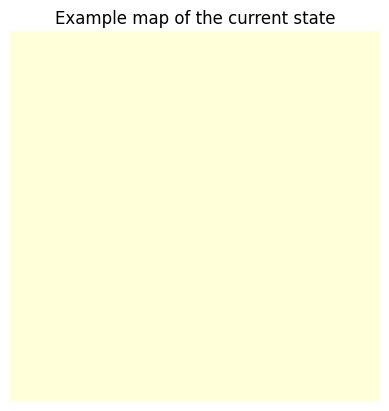

In [6]:
plot_map(ctx, "Example map of the current state")

___
## <a id='toc1_3_'></a>[Vision](#toc0_)

_Source: [vision.py](./app/vision.py)_

In [7]:
reset(ctx)

from app.vision import Vision

vision = Vision(ctx, external=False, live=False, image_path="assets/report/example_map.png")

The first module we will go through is vision. Vision is the module responsible for acquiring information about the environment the Thymio is in. It has three main components, the actual map of obstacles and their position, the position of the Thymio and its orientation.

Firstly, for the layout, to facilitate the image processing in vision we decided to use a white background where black obstacles are placed as well as the Thymio. The Thymio itself has two differently colored circles (orange and turquoise as these were the colors that provided the best contrast for detection) on top of it used for computing position and orientation of the robot. It's important to note that the center of the robot considered throughout the project corresponds to the center of the circle in the back of the Thymio.

The vision class can be initialized with the following code, bearing in mind that the use of a live stream or previously recorded image is dependent on the boolean value of the variable "live", and in the case of the live stream, the source (either external or not to the machine running the code) can be defined in the "external" variable.

Since using the camera is not interesting for our report, we will use the follwing image as an initial scene to demonstrate the module.

<div align="center" style="padding: 1rem 0;">
    <figure>
        <img src="assets/report/example_map.png" style="width: 30rem;" />
        <figcaption style="font-style: italic;">Initial scene</figcaption>
    </figure>
</div>

### <a id='toc1_3_1_'></a>[Calibration](#toc0_)

The following step should be calibrating the image acquired by the camera (or loaded from a file).

This method opens a window with the frame, in case of a live stream if the key 'N' is pressed a new frame will be captured and if 'S' is pressed the current frame will be saved. Now, in the following order, the user should click, using the left button of the mouse, the top left corner of the with square on the image, the top right corner, the bottom right corner, the bottom left corner, the circle in the back of the robot and finaly the circle in the from part of the Thymio.

Starting with the corners, they will be used to do a simple perspective wrapping in order to focus only on that part of the image. The information from the circles is used to benchmark the values that codify the color that the camera perceives as their color.

It's important to note that this method is only called the first time that vision is used given that it's assumed that the conditions like light and positioning of the camera won't change from then on.

In [8]:
vision.calibrate();

 INFO       A GUI window will open to calibrate the vision system

 INFO       Select 4 points to correct perspective (TL, TR, BR, BL)

 INFO       Then select the back landmark, then the front landmark

 INFO       Press N to take a new frame, or Q to exit

 INFO       Calibration complete!

### <a id='toc1_3_2_'></a>[Frame analysis](#toc0_)

When the following method is called the capturing and analysis of a new frame is performed and the new observation is returned to be handled in big brain (which consists of the complete table of obstacles in a 64 by 64 matrix - best sizing for it to be used by global navigation - and Thymio position in centimeters).

For the obstacle map, we detect the black pixels on the frame (obstacles), resize the frame to fit a 64 by 64 matrix and using a threshold atributte either 1 (obstacle present) or 0 (free place) to each entry of the matrix.

For the two colored circles, their center is computed by, firstly, isolating them based on the color detected in calibration and afterwards calculating its convolution with a filter with the same diameter a the circle. The position where the convolution takes its maximum value is considered as the center.

As mentioned earlier, the center of the back circle is used as the center of the robot. Orientation is computed using the center of both circles in big brain (not in vision since it should not be updated as often as the actual position, filtering is more reliable for that) ence why both values are returned.

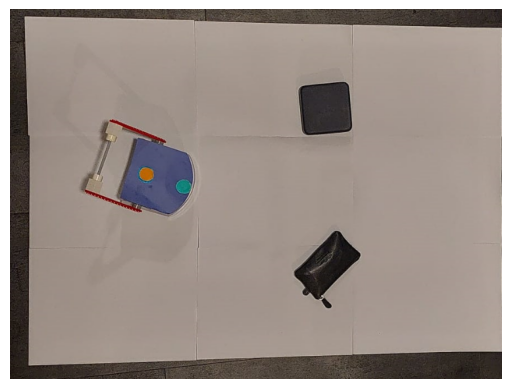

In [9]:
frame = vision._read_image()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plot_image(frame)

In order to view the image processing steps in more detail, we can enable the debug flag in the context to allow the vision module to plot various stages.

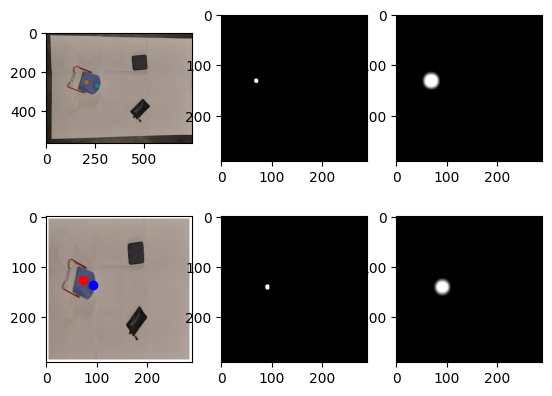

In [10]:
ctx.debug_update = True
obs = vision.next()

_Top left: the captured image. Bottom left: the transformed image, with two dots indicating the detected landmark positions. Middle column: the landmark colour pixels. Right column: the landmark colour pixels after convolution with a circular kernel, the middle should be brightest (maximum)_

In [11]:
vision_pose = (obs.back[0], obs.back[1], report_functions.angle(obs.back, obs.front))
print(vision_pose)

(29.79310344827586, 68.27586206896552, -0.4825132950224775)


Now with the matplotlib map we can display the obstacles and the thymio pose.

In [12]:
ctx.state.position = (obs.back[0], obs.back[1])
ctx.state.orientation = report_functions.angle(obs.back, obs.front)
ctx.state.obstacles = obs.obstacles

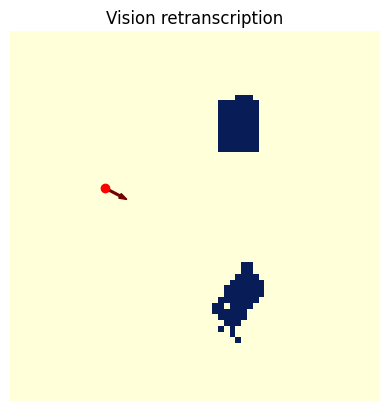

In [13]:
plot_map(ctx, "Vision retranscription")

To compare it, here is the picture again:

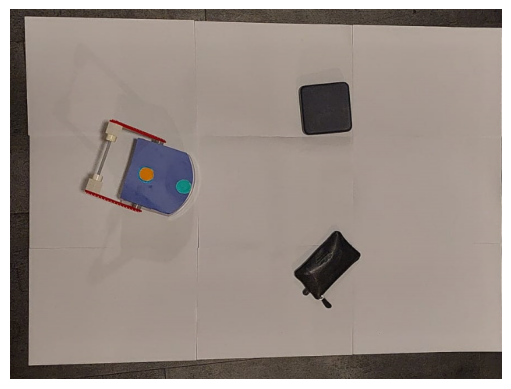

In [14]:
show_picture("assets/report/example_map.png")

___
## <a id='toc1_4_'></a>[Filtering](#toc0_)

_Source: [filtering.py](./app/filtering.py)_

In [15]:
reset(ctx)

from app.filtering import Filtering

filtering = Filtering(ctx)

Another important module of our project is filtering. Filtering is taking the information given by sensors and the camera to be able to guess where the Thymio is on the map and where it's going.

For this project we decieded to use an [Extanded Kalman Filter](app/EXF.py) and an intermediate module called [filtering](app/filtering.py) to comunicate with the main module.

The EKF was chosen for its capability of predicting a non-linear evolution of the state and also to be able to dissociate information coming from the motors and information given by the camera.

For this purpose, two functions where used: [predict](#toc1_4_1_) and [update](#toc1_4_2_). We will come back to these parts in the subsections below.

In [16]:
report_functions.start_movement_simulation(filtering)

### <a id='toc1_4_1_'></a>[Prediction](#toc0_)

A specificity of our project is the time delay between camera and motor sensors. Since the motor sensors response is faster than the one from vision, what we do is predict the position of the robot with the motor sensors at a greater frequency than the update with vision information. The time interval between each prediction is dynamic and adapts to correctly predict each time the motor sensors send variables.

The next position and orientation are then predicted. Let us run it to see how it works.

Let's take a look at our current position:

In [17]:
report_functions.print_pose(ctx)

         Thymio pose          
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Position     ┃ Orientation ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ (60.0, 60.0) │ 1.57        │
└──────────────┴─────────────┘

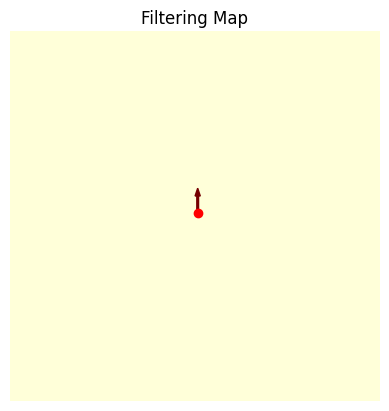

In [18]:
plot_map(ctx, "Filtering Map")

To execute a filtering step let's make the Thymio move forward:

In [19]:
# We simulate a receieved motor speed event from the Thymio
filtering.process_event({"motor.left.speed": [70], "motor.right.speed": [70]})

report_functions.stop_movement_simulation(filtering)

The state should now be updated.

                       Thymio pose                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Position                                ┃ Orientation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ (59.99999998728003, 60.290999066829684) │ 1.57        │
└─────────────────────────────────────────┴─────────────┘

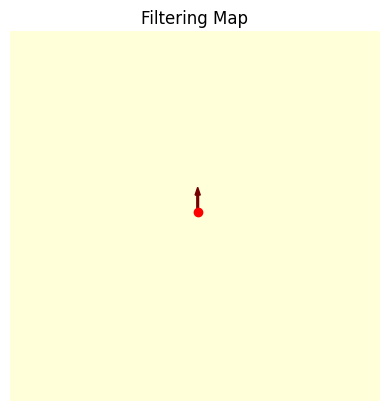

In [20]:
report_functions.print_pose(ctx)
plot_map(ctx, "Filtering Map")

Let's do it again, turning the robot this time

In [21]:
filtering.process_event({"motor.left.speed": [50], "motor.right.speed": [-50]})
report_functions.stop_movement_simulation(filtering)

                       Thymio pose                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Position                                ┃ Orientation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ (59.99999998728003, 60.290999066829684) │ 1.53        │
└─────────────────────────────────────────┴─────────────┘

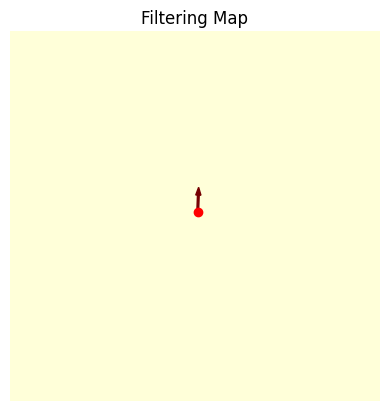

In [22]:
report_functions.print_pose(ctx)
plot_map(ctx, "Filtering Map")

we see that filtering is correctly predicting the progression of the simulated robot.

### <a id='toc1_4_2_'></a>[Update](#toc0_)

To reduce the error caused by motors, vision must be used as much as possible. If vision is lost for a while, the update step brings back the Thymio to it's correct position taking into consideration the computed prediction since it's disapearing.

To display the update function, we use the image and position of the robot given by the [Vision module](#toc1_3_).

The position after our prediction step is:

In [23]:
report_functions.print_pose(ctx)

                       Thymio pose                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Position                                ┃ Orientation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ (59.99999998728003, 60.290999066829684) │ 1.53        │
└─────────────────────────────────────────┴─────────────┘

now we update the position with the one given by vision:

In [24]:
vision_position = vision #get image from vision
filtering.update(vision_pose)

After the vision update, the new position is:

                      Thymio pose                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Position                               ┃ Orientation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ (30.22225129000691, 68.16339920828996) │ -0.46       │
└────────────────────────────────────────┴─────────────┘

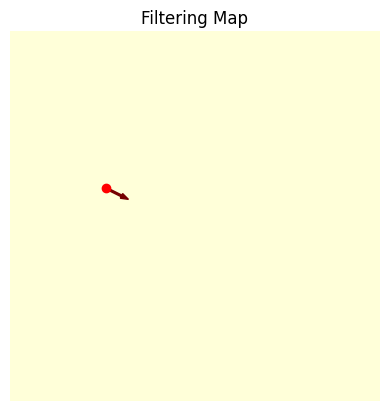

In [25]:
report_functions.print_pose(ctx)
plot_map(ctx, "Filtering Map")

___
## <a id='toc1_5_'></a>[Global navigation](#toc0_)

_Source: [global_navigation.py](./app/global_navigation.py)_

In [26]:
reset(ctx)

from app.global_navigation import GlobalNavigation

global_nav = GlobalNavigation(ctx)

The global navigation module is tasked with pathfinding. More specifically, this means computing the optimal path in order to reach the destination from the Thymio's position whilst staying clear of any obstacles picked up by the vision module.

This path is then communicated to motion control via the shared state which will then proceed to follow that path whilst giving priority to local navigation and its obstacle avoidance capabilities.

At the moment our map is completely empty. In order to invoke our pathfinding algorithm, we need to set the Thymio's position (<b style="color: #dc2626;">red</b>) and a desired end point (<b style="color: #0891b2;">cyan</b>).

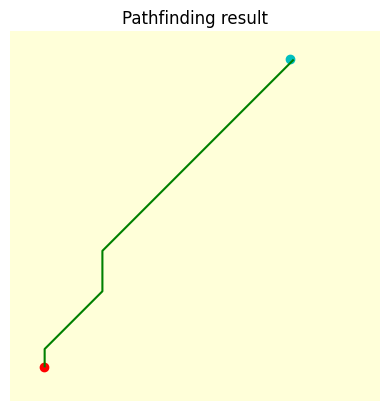

In [27]:
# Update the state
ctx.state.position = (10, 10)
ctx.state.end = (90, 110)

# Recompute the path, updating the state
await global_nav._recompute_path()

# Plot the result
plot_map(ctx, "Pathfinding result")

<div class="alert alert-block alert-info">

**Note:** As `_recompute_path()` is prefixed with an underscore, it is inferred that it is a private class method. For the purpose of this report, we will use it without shame to update our `State` with a new pathfinding computation. Under normal operation, the `ctx.scene_update` signal can be simply triggered to queue a new path recomputation using the pool.

</div>

**🎉 We have a path!**

Let's not celebrate yet, we can make this much more interesting. Our pathfinding uses an implementation of the [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm). While this may not be the fastest or most efficient algorithm, it _does_ guarantee optimal results for a given graph.

Our node graph is a grid of equaly spaced cells, where edges are made between directly adjacent cells and diagonal cells, with a cost of 1 and $\sqrt{2}$, respectively. This allows our robot to also travel diagonally and avoid grid-like movement.

<div align="center" style="padding: 1rem 0;">
    <figure>
        <img src="assets/report/dijkstra-nodes.png" style="width: 8rem;" />
        <figcaption style="font-style: italic;">Edges for a graph node to its adjacent nodes.</figcaption>
    </figure>
</div>

Ideally, we would like all nodes to be connected to every other node, given that there is a line-of-sight between them, however this comes with a huge computational burden. This simple implementation (mixed with our path optimisation algorithm covered later) provides adequate results in roughly **50 ms** for 64 subdivisions.

##### <a id='toc1_5_1_1_1_'></a>[Time for some obstacles](#toc0_)

Obstacles come directly from the vision module as a matrix of 8-bit integers, where any value other an 0 represent an occupied cell. The size of the matrix coincides with the node graph, an occupied cell will mark a node as unvisitable.

> While we could have also used a matrix of booleans, integers are slightly easier to work with and compose with other functions such as convolutions. Additionally, it has a smaller JSON serialisation footprint for sending over WebSockets to the Web UI.

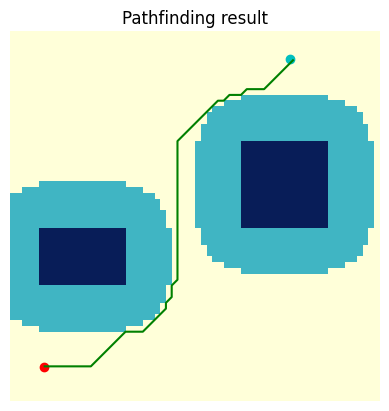

In [28]:
# Reset the matrix
ctx.state.obstacles[:, :] = 0

# Add two obstacles
ctx.state.obstacles[30:45, 40:55] = 1
ctx.state.obstacles[20:30, 5: 20] = 1

# Recompute the path
await global_nav._recompute_path()

# Plot the result
plot_map(ctx, "Pathfinding result")

The <b style="color: #075985">dark-blue</b> region represents the obstacles that we set. The <b style="color: #0891b2">cyan</b> regions are the obstacle boundaries that are generated using a convolution of a circular kernel matrix.

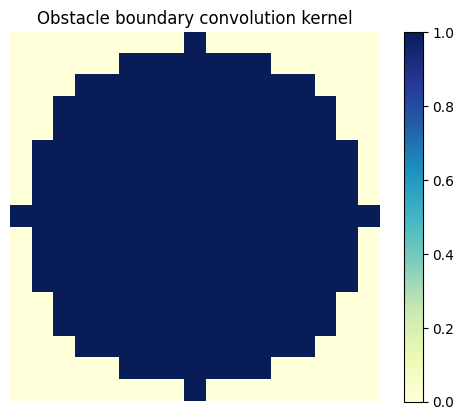

In [29]:
kernel = global_nav._safety_margin_kernel()

plot_image(kernel, "Obstacle boundary convolution kernel", colourbar=True)

The boundary is equaly treated as unvisitable by the pathfinding algorith. This ensures that the Thymio does not hit any objects with its wheels as it's navigating the path. It a gap is too small, the Thymio will not try to fit through it.

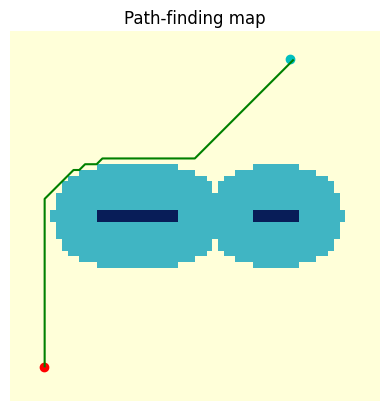

In [30]:
# Reset the matrix
ctx.state.obstacles[:,:] = 0

# Add two obstacles with a gap
ctx.state.obstacles[31:33, 15:29] = 1
ctx.state.obstacles[31:33, 42:50] = 1

# Recompute the path
await global_nav._recompute_path()

# Plot the result
plot_map(ctx, "Path-finding map")

_A gap is clearly visible between the obstacles, however the pathfinding algorithm instead is forced to take a longer path around both obstacles._

### <a id='toc1_5_2_'></a>[Path optimisation](#toc0_)

Our chosen node graph constraints our robots movements more or less to a grid, with the ability of also being able to move diagonally. This creates a lot of path waypoints, but also creates less natural-like movement.

To combat this, we have an additional post-pathfinding step to iteratively try to reduce the path to as few waypoints as necessary that have free line of sight between them. This does not find the most optimal solution, but the results are more than adequate.

The algorithm goes as follows:

1. For $i = 2,...,M-1$, where $M$ is the number of waypoints
2. Check whether there is a free line-of-sight between waypoints $w_{i-1}$ and $w_{i+1}$
3. If yes, remove the waypoint $w_i$, otherwise consider the next waypoint $w_{i+1}$

In order to calculate free line-of-sight, it's necessary to enumerate all map cells that the segment between $w_{i-1}$ and $w_{i+1}$ travels through to check their occupation status. This is done using an algorithm such as [Bresenham's line algorithm](https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm). We found an improved version that also uses integer-only math [here](https://playtechs.blogspot.com/2007/03/raytracing-on-grid.html).

In [31]:
from app.path_finding.path_optimiser import raytrace

bounds = (0, 9, 1)

@interact(y1=bounds, y2=bounds)
def plot(y1=2, y2=6):
    p1, p2 = (1, y1), (8, y2)

    matrix = np.zeros((10, 10))

    for (i, j) in raytrace(p1, p2):
        matrix[j][i] = 1

    plot_raytrace(matrix, p1, p2)

interactive(children=(IntSlider(value=2, description='y1', max=9), IntSlider(value=6, description='y2', max=9)…

Let's put this into practice using the path that we found previously.

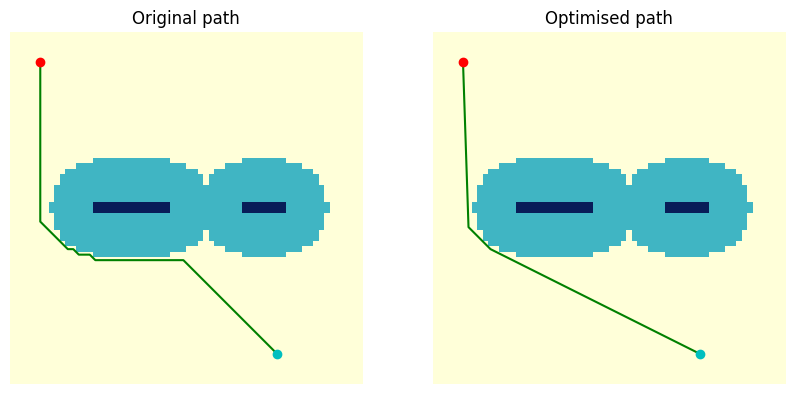

In [32]:
from app.path_finding.path_optimiser import PathOptimiser

map = create_map(ctx)

optimiser = PathOptimiser(map)

# The output of the pathfinding algorithm is in physical space [cm],
# it needs to be converted back into map indicies for this demonstration.
# Usually the path optimisation is done as an intermediate step by the
# path finding algorithm, before the conversion to physical space.
path = path_to_coords(ctx.state.path)

# The optimiser mutates the input list directly
optimised_path = optimiser.optimise(path.copy())

plot_path_optimisation(path, optimised_path, map)

Path optimisation can be toggled dynamically by setting the `ctx.state.optimise` boolean flag.

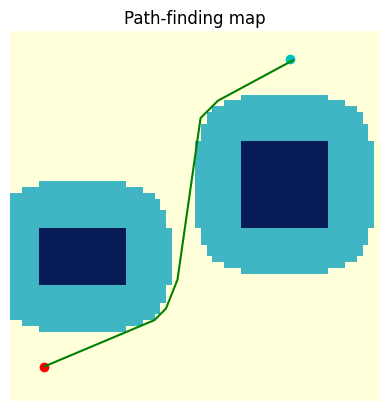

In [33]:
# Enable path optimisation
ctx.state.optimise = True

# Reset the matrix
ctx.state.obstacles[:,:] = 0

# Add two obstacles
ctx.state.obstacles[30:45, 40:55] = 1
ctx.state.obstacles[20:30, 5: 20] = 1

await global_nav._recompute_path()

plot_map(ctx, "Path-finding map")

___
## <a id='toc1_6_'></a>[Big Brain](#toc0_)

_Source: [big_brain.py](./app/big_brain.py)_

In [34]:
reset(ctx)

import app.big_brain

big_brain = app.big_brain.BigBrain(ctx)

The Big Brain module is in charge of the main application logic. It's purpose is to initialise the other modules and to orchestrate the flow of data between them.

The submodules are able to run autonomously in the background of the application using Python's `with` statement and the `asyncio` library. The `__enter__` and `__exit__` methods are used to initialise and clean up the resources used by the submodules, such as long running tasks or registering and unregistering Thymio event handlers.

Once the submodules are initialised, the main loop of the application is started. This loop is responsible for acquiring new data from the vision module and providing this data to the filtering and global navigation modules, which then trickle down to motion control and to the Web UI.

### <a id='toc1_6_1_'></a>[Significant updates](#toc0_)

To reduce the number of map updates from the vision module, we have implemented a simple thresholding function that checks whether the $L_1$ norm between the current and previous map is greater than a given threshold (i.e. a certain number of grid squares have changed). This reduces redundant pathfinding computation and also renders motion control more stable, as it is less likely to be interrupted by a sudden change in the map and path.

In [35]:
ctx.state.obstacles = np.zeros((SUBDIVISIONS, SUBDIVISIONS), dtype=np.int8)
new_map = np.zeros((SUBDIVISIONS, SUBDIVISIONS), dtype=np.int8)

# Changing a single square does not report a significant change
new_map[1, 1] = 1

big_brain.significant_change(new_map)

False

In [36]:
# Changing more than the threshold of squares should report a significant change
new_map[1:5, 1:5] = 1

big_brain.significant_change(new_map, threshold=10)

True

If the new map is deemed to have a significant change, the obstacle map is updated in `ctx.state` and the `ctx.scene_update` signal is triggered, which in turn triggers the global navigation module to recompute the path.

Regardless of whether the map has changed or not, the new detected position is sent to the filtering module in order to update the robot's position and attempt to correct any drift.

### <a id='toc1_6_2_'></a>[Christmas animation](#toc0_)

Once the robot reaches the arrival point, it will start to play a celebration sequence. This is also handled by the big brain module, invoking the `ChristmasCelebration` class to play various actions, such as dropping the bauble using the second Thymio node.

## <a id='toc1_7_'></a>[Motion control](#toc0_)

_Source: [motion_contor.py](./app/motion_control.py)_

In [37]:
reset(ctx)

from app.motion_control import MotionControl

control = MotionControl(ctx)

The motion control block has the responsability to move the Thymio. It has two types of control; positional control `controlPosition()` which has the objective to go to a special set of coordinates and reactive control `controlWithDistance()` which has the objective to avoid any walls and get around them following their left.

Motion control also has the responsability to update the targeted waypoint if it has been reached and commmunicate to the rest of the program if the last waypoint is reached.

##### <a id='toc1_7_1_1_1_'></a>[Responsibilities](#toc0_)

1. Update the waypoint when arrived
2. If arrived to the end of the path, change the state to let the rest of the program know

Let's simulate the robot following a path!

##### <a id='toc1_7_1_1_2_'></a>[Setup](#toc0_)

1. We have do define a path (noramlly given by BigBrain in Global-nav)
2. We have to define which waypoint we are aiming


##### <a id='toc1_7_1_1_3_'></a>[Simulation](#toc0_)

1. We control the Thymio to go to the specified waypoint we want 
2. We update his position by updating filtering

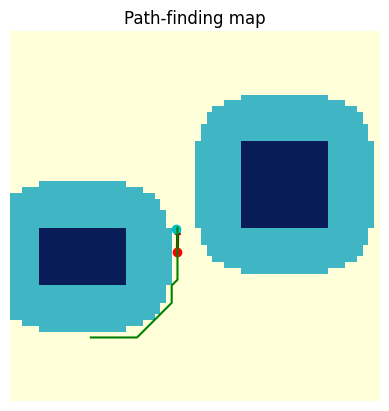

In [38]:
report_functions.start_movement_simulation(filtering)

reset(ctx)

# Set some locations in the state
ctx.state.position = (25, 18)
ctx.state.orientation = 0
ctx.state.end = (53, 55)
ctx.state.reactive_control = False

# Setup the filtering module
filtering.update((*ctx.state.position, ctx.state.orientation))

# Reset the matrix
ctx.state.obstacles[:,:] = 0

# Add two obstacles
ctx.state.obstacles[30:45, 40:55] = 1
ctx.state.obstacles[20:30, 5: 20] = 1

# Recompute the path
await global_nav._recompute_path()

# Setup the motion control module
ctx.state.next_waypoint = 0
control.setNewWaypoint(0)

path_length = len(ctx.state.path) - 1
while ctx.state.next_waypoint_index < path_length:
    # Get the desired control (#1)
    (arrived, vLC, vRC) = control.controlPosition()

    # Plot current state
    clear_output(wait=True)
    plot_map(ctx, "Path-finding map")
    
    if arrived:
        # load the next waypoint to aim if arrived to the previous one
        control.setNewWaypoint(1)
    
    # Send the motor speed to the filtering module as a Thymio event (#2)
    filtering.process_event({"motor.left.speed": [int(vLC)], "motor.right.speed": [int(vRC)]})
    await sleep(0.1)

We need to introduce the Local Navigation block to understand completely the `controlWithDistance()` function. The full explaination can be found in the [local navigation section](#toc1_8_).

Motion control receives the distance array which contains how far from the obstacle the Thymio is.

Distance control is very simple:

1. If no obstacles: Thymio will try to go forward and turn a bit to the right trying to find wall to follow on his left-hand side
2. If an obstacle is close enough: 
    1. If the Thymio is really close to the obstalce, it will move backward
    2. It will move to the right trying to avoid the obstacle

Depending if the triggered sensor is frontal or from the sides, the reaction will be similar but more or less accentuated.

In [39]:
from app.local_navigation import LocalNavigation

local_nav = LocalNavigation(ctx, control)

In [40]:
local_nav.process_event(variables={"prox.horizontal": [2800,3000,3300,3000,3400,2000,2000]}) #simulate the sensors 
print("Distance array: ", ctx.state.relative_distances[:-2])
(arrived, vLC, vRC) = control.controlWithDistance()
print({ "vLC": vLC, "vRC": vRC })
print("The Thymio is going foward and turning a bit to the right to try figure out where the wall is\n")


local_nav.process_event(variables={"prox.horizontal": [2800,3000,4500,3000,3400,2000,2000]}) #simulate the sensors 
print("Distance array: ", ctx.state.relative_distances[:-2])
(arrived, vLC2, vRC2) = control.controlWithDistance()
print({ "vLC": vLC2, "vRC": vRC2 })
print("The Thymio is going backward and turning to the left to avoid the wall")

Distance array:  [8.118942731277533, 8.03041825095057, 6.293286219081272, 8.03041825095057, 5.949554896142433]
{'vLC': 54, 'vRC': 66}
The Thymio is going foward and turning a bit to the right to try figure out where the wall is

Distance array:  [8.118942731277533, 8.03041825095057, 3.107142857142857, 8.03041825095057, 5.949554896142433]
??
{'vLC': 20, 'vRC': -55}
The Thymio is going backward and turning to the left to avoid the wall


In our program, we are calling the funtion `update_motor_control()`, this function chooses the correct control defined in the Local navigation block. The function will also update the targeted waypoint if the Thymio arrives to the waypoint

## <a id='toc1_8_'></a>[Local navigation](#toc0_)

_Source: [local_navigation.py](./app/local_navigation.py)_

In [41]:
reset(ctx)

from app.local_navigation import LocalNavigation

local_nav = LocalNavigation(ctx, control)

The Local Navigation block has the responsability to trigger the control by waypoint or the control with distance state depending if the Thymio senses an obstacle close to his sensors. It communicates the type of control through the state variable : `reactive_control`. 

This block can also detect and locate obstacle positions with the function: `getWallRelative()`.

This function does not exist in the project but for the report it is very useful because we can simulate a measure of the Thymio's sensors and update the state.

In [42]:
def simulateSensors(sensorsValues):
    # simulate a Thymio proximity event
    local_nav.process_event({"prox.horizontal": sensorsValues})

In [43]:
simulateSensors([4500,3000,3300,4000,3400,2000,2000])
print(ctx.state.relative_distances)

[3.107142857142857, 8.03041825095057, 6.293286219081272, 4.775308641975308, 5.949554896142433, -1.0, -1.0]


The function `getWallRelative()` returns the relative position of the sensed walls (relative because it depends on the position and orientation of the Thymio). This function could be useful if in the future we want to implement a scan of obstacles with the Thymio.

In [44]:
simulateSensors([3000,3000,3300,4000,3400,2000,2000])
relative_obstacle_position = local_nav.getWallRelative()
print(relative_obstacle_position)

[[-10.218696899385943, 8.663677806001125], [-5.8750114628860715, 12.239607214345984], [3.8535264121580146e-16, 11.793286219081272], [4.670236150183575, 9.153662854359808], [9.326552534176972, 7.540616942526064], None, None]


Now we enter the main part of the block: the type of control trigger depending on the sensors values.
The function `should_freestyle()` defines if the Thymio should enter the reactive control mode and updates the state. It will be read by the Motion control block for it to apply the correct control. 


In [45]:
ctx.state.reactive_control = False

simulateSensors([3000,3000,3000,3000,3400,2000,2000]) #Reading of sensors far away from an obstacle
print("relative distances : ", ctx.state.relative_distances[:-2])
local_nav.should_freestyle()
print("should enter local navigation ? : ", ctx.state.reactive_control)


simulateSensors([3000,4500,4500,3000,3400,2000,2000])#Reading of sensors close to an obstacle, the front one at 4500
print("relative distances : " ,ctx.state.relative_distances[:-2])
local_nav.should_freestyle()
print("should enter local navigation ? : ", ctx.state.reactive_control)

relative distances :  [7.366300366300366, 8.03041825095057, 7.366300366300366, 8.03041825095057, 5.949554896142433]
should enter local navigation ? :  False
relative distances :  [7.366300366300366, 3.3496503496503496, 3.107142857142857, 8.03041825095057, 5.949554896142433]
should enter local navigation ? :  True


## <a id='toc1_9_'></a>[Putting it all together](#toc0_)

Now that we have covered all the different modules of our application, we can put them together to run the whole thing.

There are two ways to run the application.

### <a id='toc1_9_1_'></a>[Running from the terminal](#toc0_)

This is the **recommended** approach, it's more robust and allows you to see better application logs, stop the application with Ctrl+C and also use keyboard input using stdin.


```powershell
$ python -m app
```


### <a id='toc1_9_2_'></a>[Running from Jupyter](#toc0_)

On modern versions of IPython (7+), it's possible to run the application from a Jupyter notebook using the top-level await syntax. From our experiments, the coloured terminal logging, GUI calibration window and keyboard input should all work.

Note that running the following cell will block the notebook kernel until the cell is interrupted (the future is cancelled), the kernal is restarted or the Web UI is used to terminal the application.

In [ ]:
from asyncio import CancelledError
from app.__main__ import init


try:
    await init()

except CancelledError:
    pass